# Example 2d GP in Mass-Accretion space

A worked 2d example with GPy

## Imports etc

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

In [2]:
%run ~/.jupyter/config.ipy

# 1d example with noisy training data

In [35]:
def f(x):
    return np.sin(x) * np.sqrt(x)

m_var = 0.5

train_x = np.random.random(size=10)*10
train_y = f(train_x) + np.random.normal(size=len(train_x), scale=np.sqrt(m_var), loc=0)
test_x = np.linspace(0, 10, num=4000)

train_xr = train_x.reshape((-1, 1))
train_yr = train_y.reshape((-1, 1))
test_xt = test_x.reshape((-1, 1))

## With gaussian noise

In [48]:
k = GPy.kern.RBF(1)
m = GPy.models.GPRegression(train_xr, train_yr, k)

# We know what the error on each point is. We need to fix this. Try comment it out and see what happens!
m.Gaussian_noise.constrain_fixed(m_var)

array([0])

In [49]:
m.optimize(messages=True)

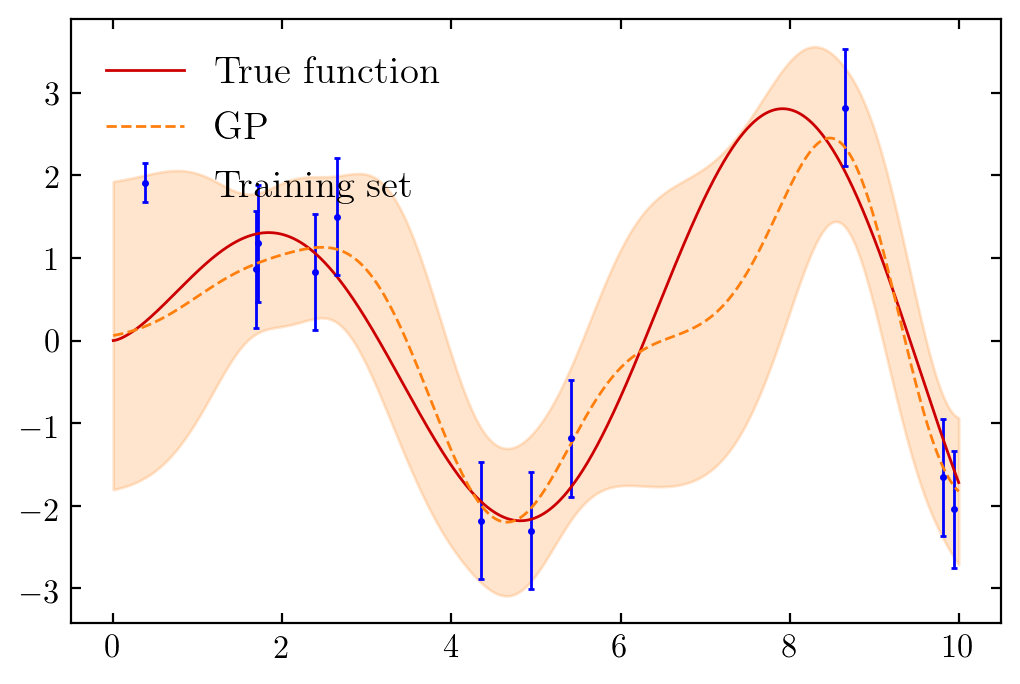

In [50]:
test_y = m.predict(test_xt)
test_y = [test_y[i].flatten() for i in range(len(test_y))]


_, ax = plt.subplots()
ax.plot(test_x, f(test_x), label="True function")
ax.errorbar(train_x, train_y, yerr=np.sqrt(m_var), marker=".", ls="none", label="Training set")

l = ax.plot(test_x, test_y[0], ls="--", label="GP")
ax.fill_between(test_x, test_y[0] + np.sqrt(test_y[1]), test_y[0] - np.sqrt(test_y[1]), alpha=0.2, color=l[0].get_color())
ax.legend()

## With fixed kernel

In [71]:
k_rbf = GPy.kern.RBF(1)
k_fixed = GPy.kern.Fixed(1, np.diag(np.full_like(train_x, m_var)))
m = GPy.models.GPRegression(train_xr, train_yr, k_rbf + k_fixed)

# We know what the error on each point is. We need to fix this. Try comment it out and see what happens!
m.Gaussian_noise.constrain_fixed(0)
m.kern.fixed.variance.constrain_fixed(1)

array([0])

In [72]:
m.optimize(messages=True)

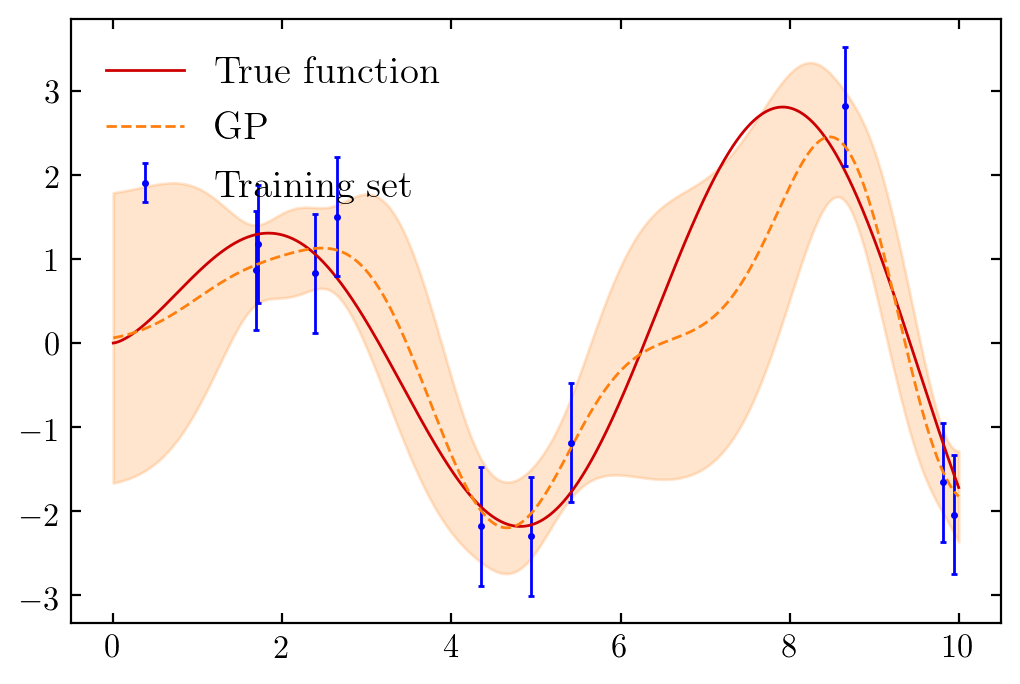

In [73]:
test_y = m.predict(test_xt, kern=m.kern.rbf)
test_y = [test_y[i].flatten() for i in range(len(test_y))]


_, ax = plt.subplots()
ax.plot(test_x, f(test_x), label="True function")
ax.errorbar(train_x, train_y, yerr=np.sqrt(m_var), marker=".", ls="none", label="Training set")

l = ax.plot(test_x, test_y[0], ls="--", label="GP")
ax.fill_between(test_x, test_y[0] + np.sqrt(test_y[1]), test_y[0] - np.sqrt(test_y[1]), alpha=0.2, color=l[0].get_color())
ax.legend()

# 2d example

## Data

This is some data that I think Enia gave me showing the quality of fit for some mass and gamma bins to some data (I think delta sigma profiles). She wanted to run an MCMC on this data to find the posterior distribution of mass gamma. Rather than run a straight MCMC, this is the training set for a GP that can then be used for the MCMC.

In [3]:
data = np.load("adaptive_bins_all_gamma_m_13_15_chi2_processed_hr_1000.npy")

mean_mass = np.mean(data[:,:2], axis=1)
mean_gamma = np.mean(data[:,2:4], axis=1)
chi2 = data[:,4]

Naively, it seems like M~13.7 with no strong constraints on gamma


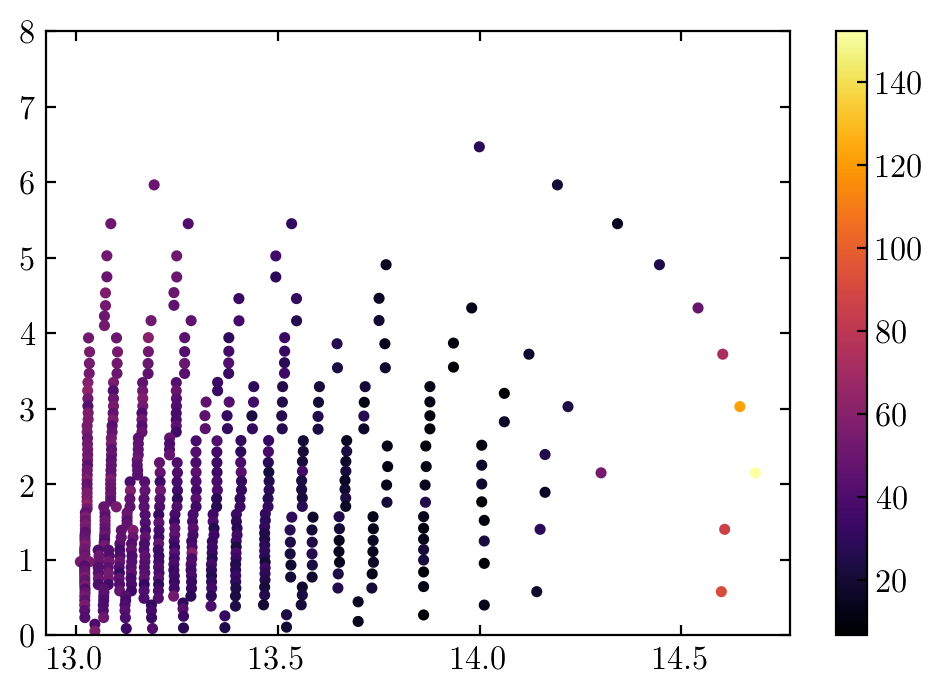

In [4]:
fig, ax = plt.subplots()
img = ax.scatter(mean_mass, mean_gamma, c=chi2, cmap="inferno")
fig.colorbar(img)
ax.set(ylim=(0, 8))
print("Naively, it seems like M~13.7 with no strong constraints on gamma")

## GP

In [28]:
# Construct the data and target vectors - each row is a single data point
x = np.vstack((mean_mass, mean_gamma)).T
y = chi2.reshape(-1, 1)

# Specify a 2d RBF kernel. We don't care what the initial variance/length scale is because we optimize them below. 
# Possibly setting them would speed up that process, but NBD.
# Important that we specify automatic relevance determination (ARD). This allows different length scales for different axes
k = GPy.kern.RBF(2, ARD=True)
m = GPy.models.GPRegression(x, y, k)

# Let's say we know exactly what the uncertainty on our data points is
#m.Gaussian_noise.constrain_fixed(20)

In [29]:
m.optimize(messages=True)

## results

In [30]:
# Construct a test grid so that we can check if this is any good
xx, yy = np.meshgrid(np.linspace(13, 14.5), np.linspace(0, 6))
test_x = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

In [31]:
# Use the GP to predict the y values at the x in our test grid
test_y = m.predict(test_x)

As expected M (13.7 - 14) but no constraints on gamma


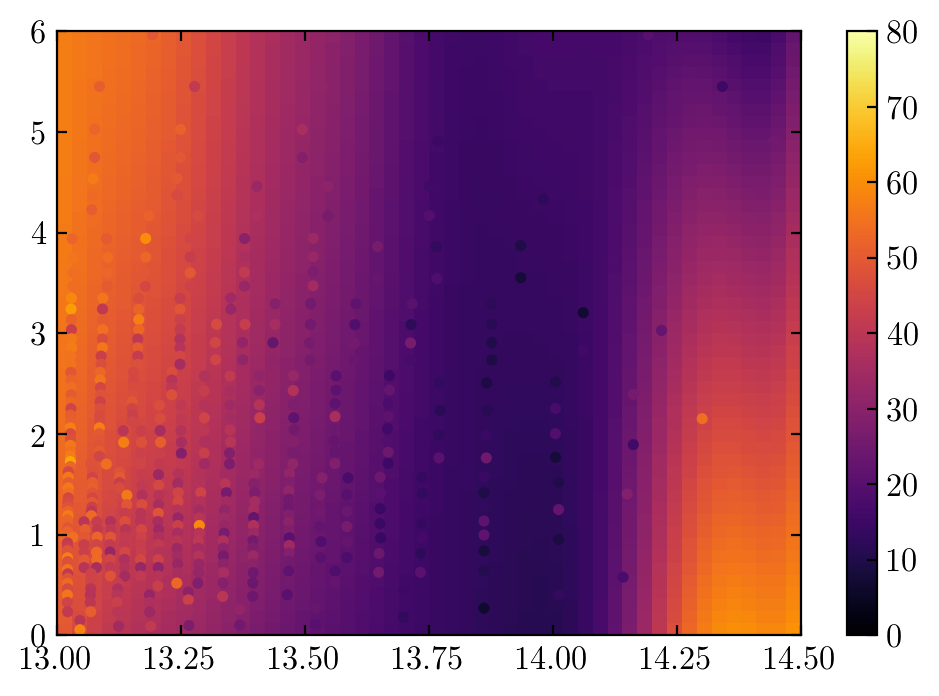

In [32]:
# Plot the training points on the test grid to see if it is close
c_max = 80

fig, ax = plt.subplots()
img = ax.imshow(
    test_y[0].reshape(xx.shape),
    origin="lower",
    extent=[xx[0][0], xx[0][-1], yy[0][0], yy[-1][0]],
    aspect="auto",
    cmap="inferno",
)
img.set_clim(0, c_max)

img2 = ax.scatter(mean_mass, mean_gamma, c=chi2, cmap="inferno")
img2.set_clim(0, c_max)

ax.set(
    xlim=(xx[0][0], xx[0][-1]),
    ylim=(yy[0][0], yy[-1][0]),
)
fig.colorbar(img)

print("As expected M (13.7 - 14) but no constraints on gamma")

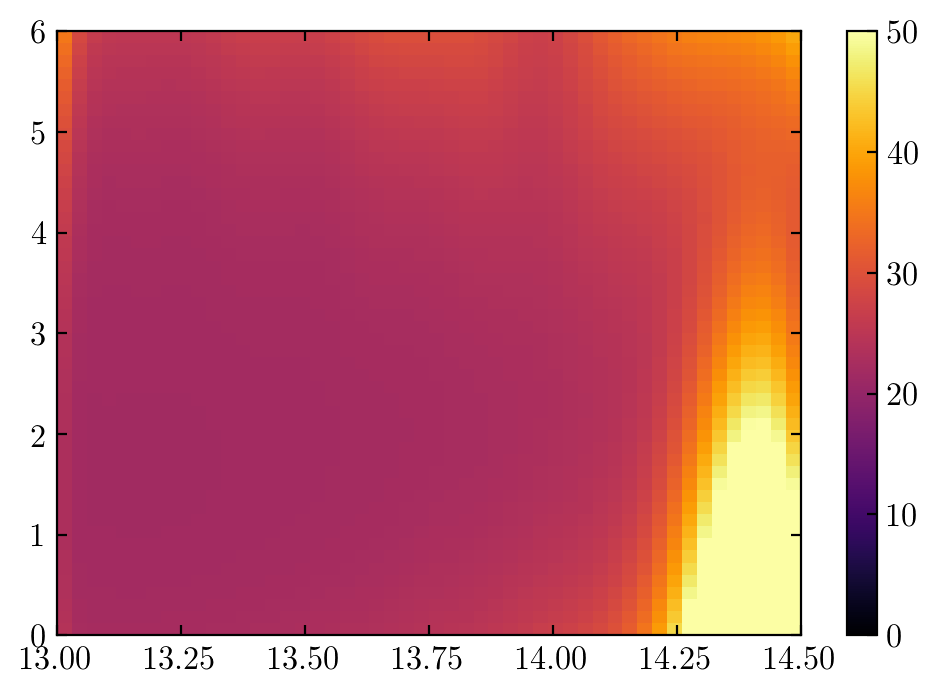

In [33]:
# Plot the uncertainties. These are quite high
# It looks like there is a decent uncertainty on the data? Nearby points often have quite different chi2?
fig, ax = plt.subplots()
img = ax.imshow(
    test_y[1].reshape(xx.shape),
    origin="lower",
    extent=[xx[0][0], xx[0][-1], yy[0][0], yy[-1][0]],
    aspect="auto",
    cmap="inferno",
)
fig.colorbar(img)
img.set_clim(0, 50)